# Time Series Analysis

In [9]:
# import packages
import gc
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
from lightgbm import plot_tree
from graphviz import Digraph
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import roc_auc_score,mean_squared_error
import time
import pickle

### <i> White noise plotting</i>

mean = 0.021 and std = 0.99


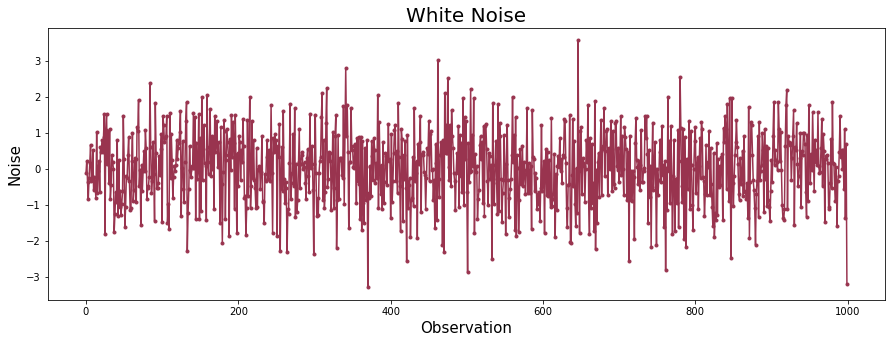

In [113]:
white_noise = np.random.normal(size=1000)
plt.figure(figsize=(15, 5))
plt.plot(white_noise,color= '#99344f',marker = '.')
plt.title('White Noise',fontsize = 20)
plt.xlabel('Observation',fontsize = 15) #xlabel
plt.ylabel('Noise', fontsize = 15)#ylabel
plt.style.context('seaborn-deep')
mean, std = white_noise.mean(), white_noise.std()
print(f'mean = {np.round(mean,3)} and std = {np.round(std,3)}')

In [11]:
# Importing statsmodels modules 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [101]:
def tsplot(y, lags=None, figsize=(10, 8), style='seaborn-deep'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        qq_ax = plt.subplot2grid(layout, (1, 0))
        pp_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return
def autocorrelation_plot(y, lags=None, figsize=(15, 5), style='seaborn-deep'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (1, 2)
        acf_ax = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (0, 1))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
    return

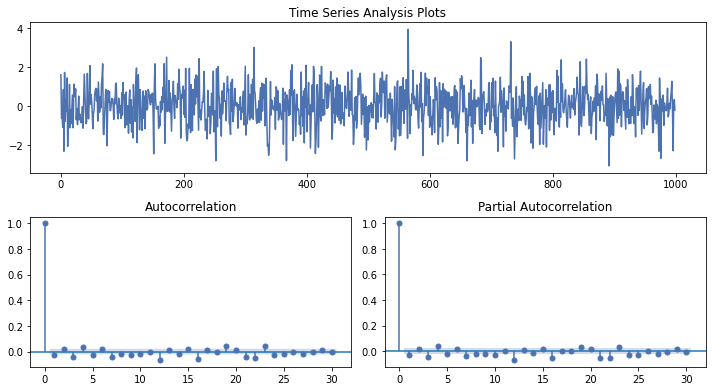

In [61]:
np.random.seed(1)
# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

We can see that process appears to be random and centered about zero. The autocorrelation (ACF) and partial autocorrelation (PACF) plots also indicate no significant serial correlation. Keep in mind we should see approximately 5% significance in the autocorrelation plots due to pure chance as a result of sampling from the Normal distribution. Below that we can see the QQ and Probability Plots, which compares the distribution of our data with another theoretical distribution. In this case, that theoretical distribution is the standard normal distribution. Clearly our data is distributed randomly, and appears to follow Gaussian (Normal) white noise, as it should.

## Auto Regressive Process 

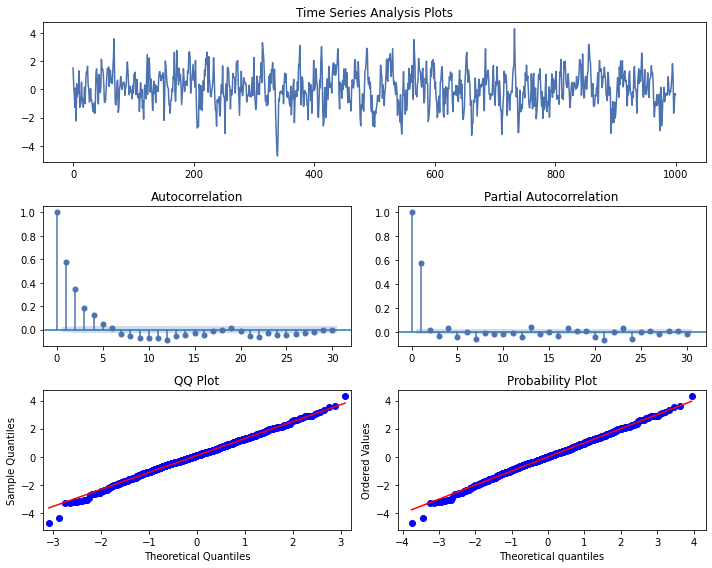

In [53]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

As expected the distribution of our simulated AR(1) model is normal. There is significant serial correlation between lagged values especially at lag 1 as evidenced by the PACF plot. 

Now we can fit an AR(p) model using Python's statsmodels. First we fit the AR model to our simulated data and return the estimated alpha coefficient. Then we use the statsmodels function "select_order()" to see if the fitted model will select the correct lag. If the AR model is correct the estimated alpha coefficient will be close to our true alpha of 0.6 and the selected order will equal 1.



In [73]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))

Wall time: 54.3 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


Looks like we were able to recover the underlying parameters of our simulated data. Let's simulate an AR(2) process with alpha_1 = 0.666 and alpha_2 = -0.333. For this we make use of statsmodel's "arma_generate_samples()" function. This function allows us to simulate an AR model of arbitrary orders. Note that there are some peculiarities of Python's version which requires us to take some extra steps before using the function.

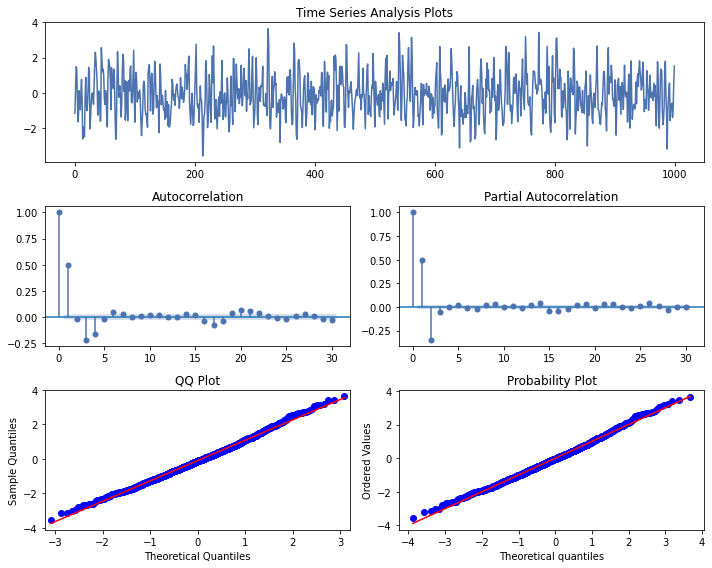

In [75]:
# Simulate an AR(2) process
lags= 30
n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=lags)

In [77]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
  .format(mdl.params[0],mdl.params[1], est_order))
print('\ntrue coefs = {} | true order = {}'
  .format([.666,-.333], true_order))
  
# coef estimate: 0.6291 -0.3196 | best lag order = 2
# true coefs = [0.666, -0.333] | true order = 2


coef estimate: 0.6518 -0.3111 | best lag order = 3

true coefs = [0.666, -0.333] | true order = 2


# Working with real data 

In [1]:
from pandas import read_csv 
from matplotlib import pyplot 
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
series.index = series.Date
series = series.drop('Date',axis = 1)
print(series)

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
...          ...
1990-12-27  14.0
1990-12-28  13.6
1990-12-29  13.5
1990-12-30  15.7
1990-12-31  13.0

[3650 rows x 1 columns]


## Analysing autocorrelations and Partial AutoCorrelations

In [94]:
from statsmodels.tsa.stattools import acf
autocorrelations = acf(x= series, adjusted=False, nlags=30, qstat=False, fft=True, alpha=None)
autocorrelations

array([1.        , 0.774268  , 0.6302866 , 0.58529312, 0.57774567,
       0.57728013, 0.57510412, 0.57437039, 0.56782622, 0.56120131,
       0.54668689, 0.53793111, 0.54012564, 0.54247126, 0.53688723,
       0.53429917, 0.53043593, 0.52911166, 0.53037444, 0.52280732,
       0.52303677, 0.52224579, 0.51426684, 0.49837745, 0.49302665,
       0.49946731, 0.50428521, 0.50068173, 0.49157081, 0.48146406,
       0.47421245])

In [99]:
from statsmodels.tsa.stattools import acf
acf(x = series,fft = False,nlags=30)

array([1.        , 0.774268  , 0.6302866 , 0.58529312, 0.57774567,
       0.57728013, 0.57510412, 0.57437039, 0.56782622, 0.56120131,
       0.54668689, 0.53793111, 0.54012564, 0.54247126, 0.53688723,
       0.53429917, 0.53043593, 0.52911166, 0.53037444, 0.52280732,
       0.52303677, 0.52224579, 0.51426684, 0.49837745, 0.49302665,
       0.49946731, 0.50428521, 0.50068173, 0.49157081, 0.48146406,
       0.47421245])

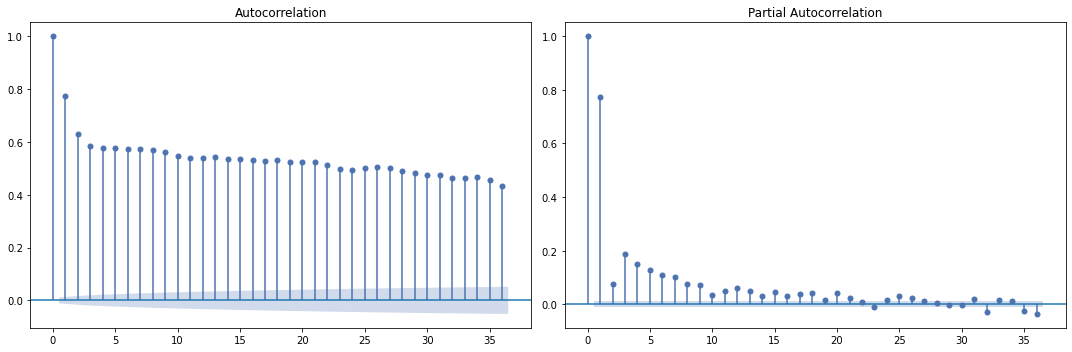

In [102]:
autocorrelation_plot(y= series['Temp'])

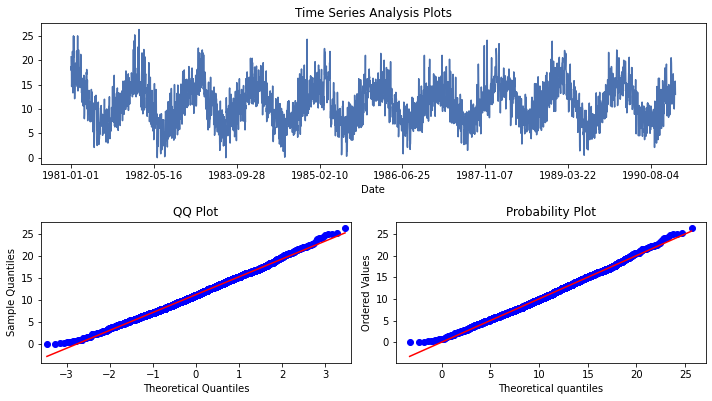

In [103]:
tsplot(y= series['Temp'])